In [22]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE          # oversampling
from imblearn.pipeline import Pipeline            # pipeline compatibile
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [23]:
# Importing the dataset
clean_credit_card_data = pd.read_csv('Dataset/model_credit_card_data.csv')

In [24]:
# -------- drop delle righe con target = 0 ------------
clean_credit_card_data = clean_credit_card_data[clean_credit_card_data["Credit_Score"] != 0].copy()   # .copy() per sicurezza (evita SettingWithCopyWarning)

print("Distribuzione dopo il drop della classe 0:")
print(clean_credit_card_data["Credit_Score"].value_counts(dropna=False))


Distribuzione dopo il drop della classe 0:
Credit_Score
2    52974
1    28953
3    17721
Name: count, dtype: int64


## 1) Decision Tree Classifier

Decision trees are a type of supervised learning algorithm that can be used for both classification and regression tasks. They work by splitting the data into subsets based on the value of input features, creating a tree-like structure where each node represents a feature and each branch represents a decision based on that feature.



In [25]:
# Importing necessary libraries for model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Selecting the target variable and features
X = clean_credit_card_data.drop(columns=['Credit_Score'])
y = clean_credit_card_data['Credit_Score']

# Encoding categorical variables if any
X = pd.get_dummies(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_orig = X_train.copy()
y_train_orig = y_train.copy()


In [26]:
# 4.1 – calcoliamo quante osservazioni ha la classe di maggioranza
maj_size = y_train.value_counts().max()

# 4.2 – facciamo in modo che TUTTE le altre classi vengano portate a quella taglia
smote = SMOTE(
    sampling_strategy='not majority',  # ovvero: oversampla tutte tranne la più grande
    k_neighbors=5,                     # riduci a 3 se le classi 0/3 hanno < 5 es.
    random_state=42
)


In [27]:
# # Build the Decision Tree model with a maximum of 10 features
# decision_tree_model = DecisionTreeClassifier(random_state=42, max_features=10)
# decision_tree_model.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = decision_tree_model.predict(X_test)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))
# print("\nAccuracy:")
# print(decision_tree_model.score(X_test, y_test))

In [28]:
clf = DecisionTreeClassifier(random_state=42, max_features=10)

pipe = Pipeline([
    ('smote', smote),        # <-- viene applicato SOLO sul training interno di CV
    ('model', clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train, y_train,
                         cv=cv, scoring='f1_macro')   # macro = pesa tutte le classi uguale
print(f"F1-macro medio CV: {scores.mean():.3f} ± {scores.std():.3f}")

F1-macro medio CV: 0.961 ± 0.002


In [29]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))


Confusion matrix:
[[ 5627   240     0]
 [  199 10248   126]
 [    0   145  3345]]

Classification report:
              precision    recall  f1-score   support

           1       0.97      0.96      0.96      5867
           2       0.96      0.97      0.97     10573
           3       0.96      0.96      0.96      3490

    accuracy                           0.96     19930
   macro avg       0.96      0.96      0.96     19930
weighted avg       0.96      0.96      0.96     19930



In [30]:
tree_model = pipe.named_steps['model']   


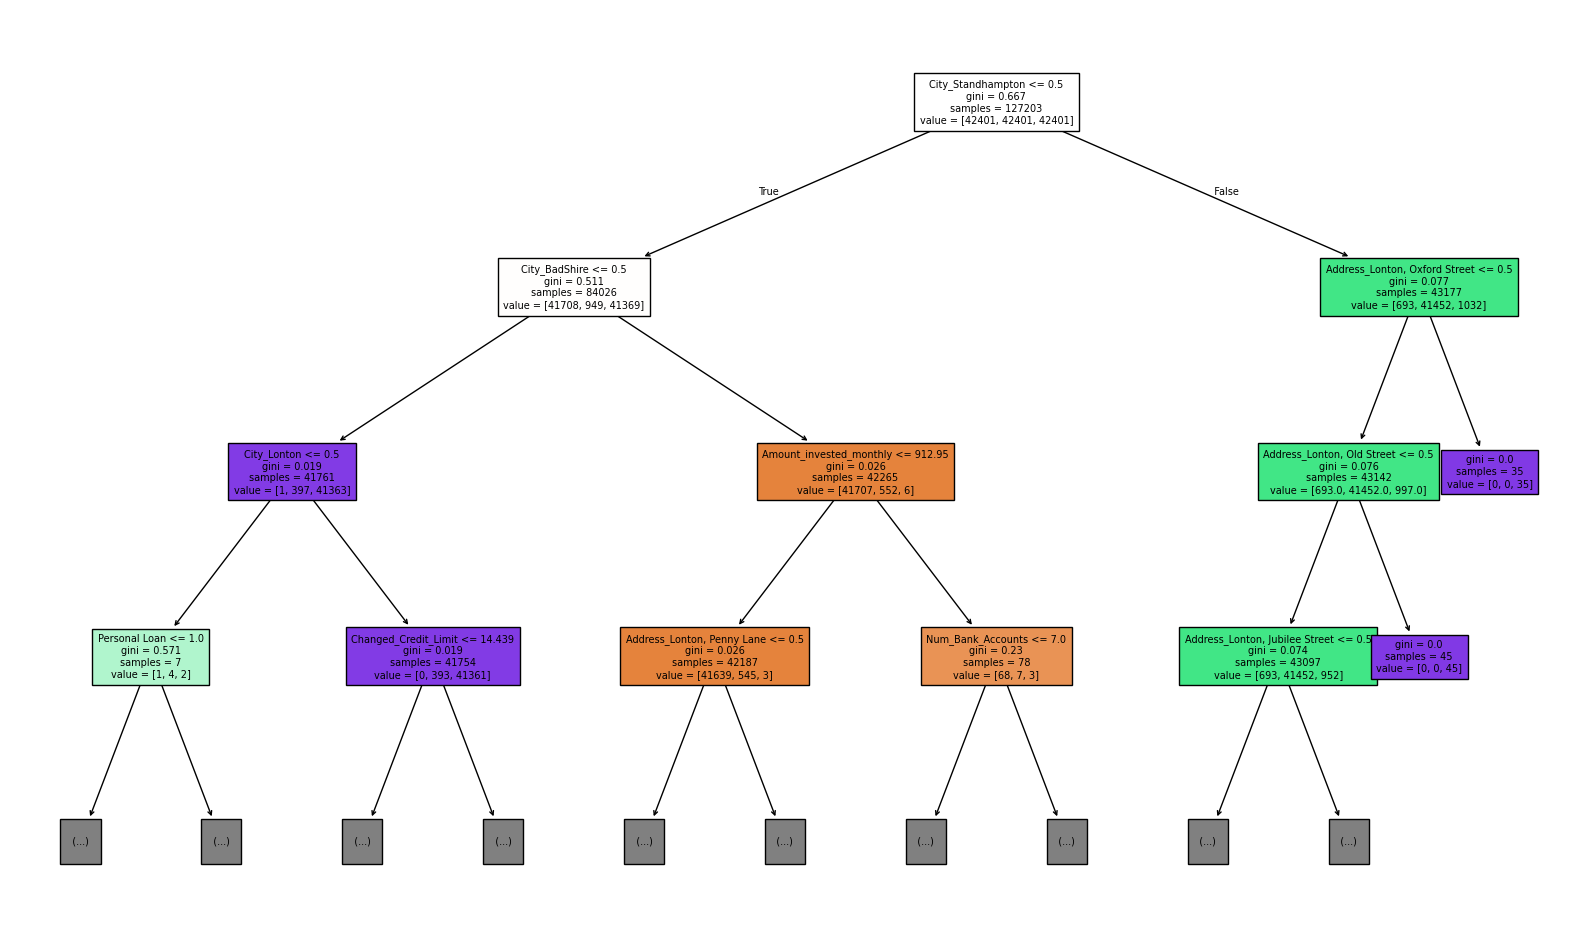

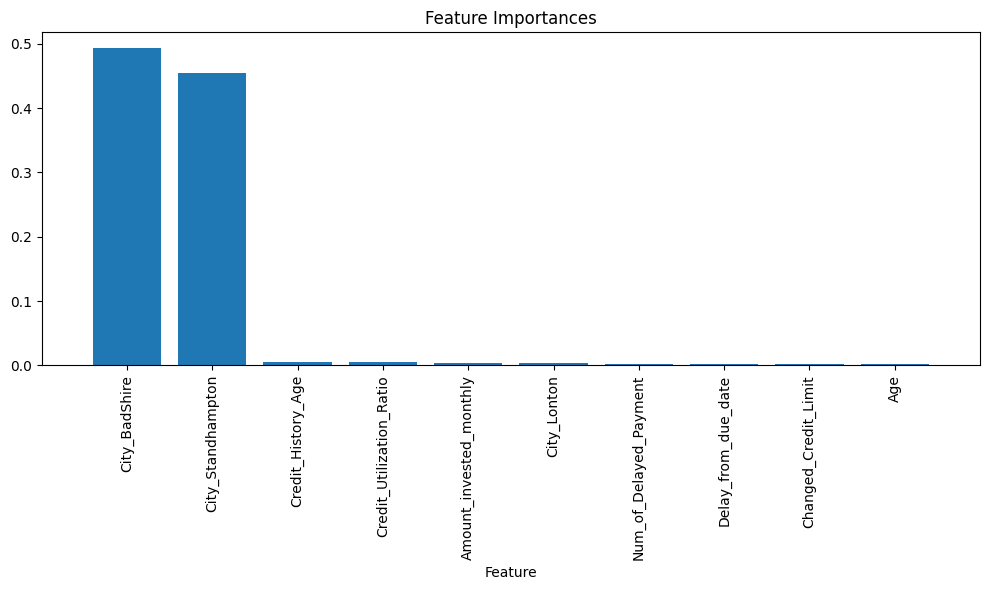

In [31]:
# Visualizing the Decision Tree with a maximum depth of 3
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 12))  # Increased figure size for better readability
plt.title("Decision Tree Visualization (max_depth=3)", fontsize=16)
plot_tree(tree_model, filled=True, feature_names=X.columns, max_depth=3, fontsize=7)
plt.show()

# Feature Importance
importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
importances = importances[indices]

# Plotting the feature importances (top 10)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


In [32]:
from imblearn.under_sampling import RandomUnderSampler

# 2.1 – scegli la strategia
rus = RandomUnderSampler(
    sampling_strategy = 'majority',   # riduce SOLO la classe più numerosa di 1/3
    random_state=42
)

# 2.2 – modello
clf_under = DecisionTreeClassifier(random_state=42, max_features=10)

# 2.3 – pipeline: under-sampler → modello
pipe_under = Pipeline([
    ('under', rus),
    ('model', clf_under)
])


In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe_under,
    X_train_orig, y_train_orig,
    cv=cv,
    scoring='f1_macro'
)
print(f"F1-macro (undersampling)   : {scores.mean():.3f} ± {scores.std():.3f}")

# Fit finale e test reale
pipe_under.fit(X_train_orig, y_train_orig)
y_pred_under = pipe_under.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion matrix (undersampling):")
print(confusion_matrix(y_test, y_pred_under))

print("\nClassification report:")
print(classification_report(y_test, y_pred_under))


F1-macro (undersampling)   : 0.957 ± 0.001

Confusion matrix (undersampling):
[[5731  135    1]
 [ 353 9984  236]
 [   0   92 3398]]

Classification report:
              precision    recall  f1-score   support

           1       0.94      0.98      0.96      5867
           2       0.98      0.94      0.96     10573
           3       0.93      0.97      0.95      3490

    accuracy                           0.96     19930
   macro avg       0.95      0.96      0.96     19930
weighted avg       0.96      0.96      0.96     19930



In [34]:
pipe_under.fit(X_train_orig, y_train_orig)
y_pred_under = pipe_under.predict(X_test)


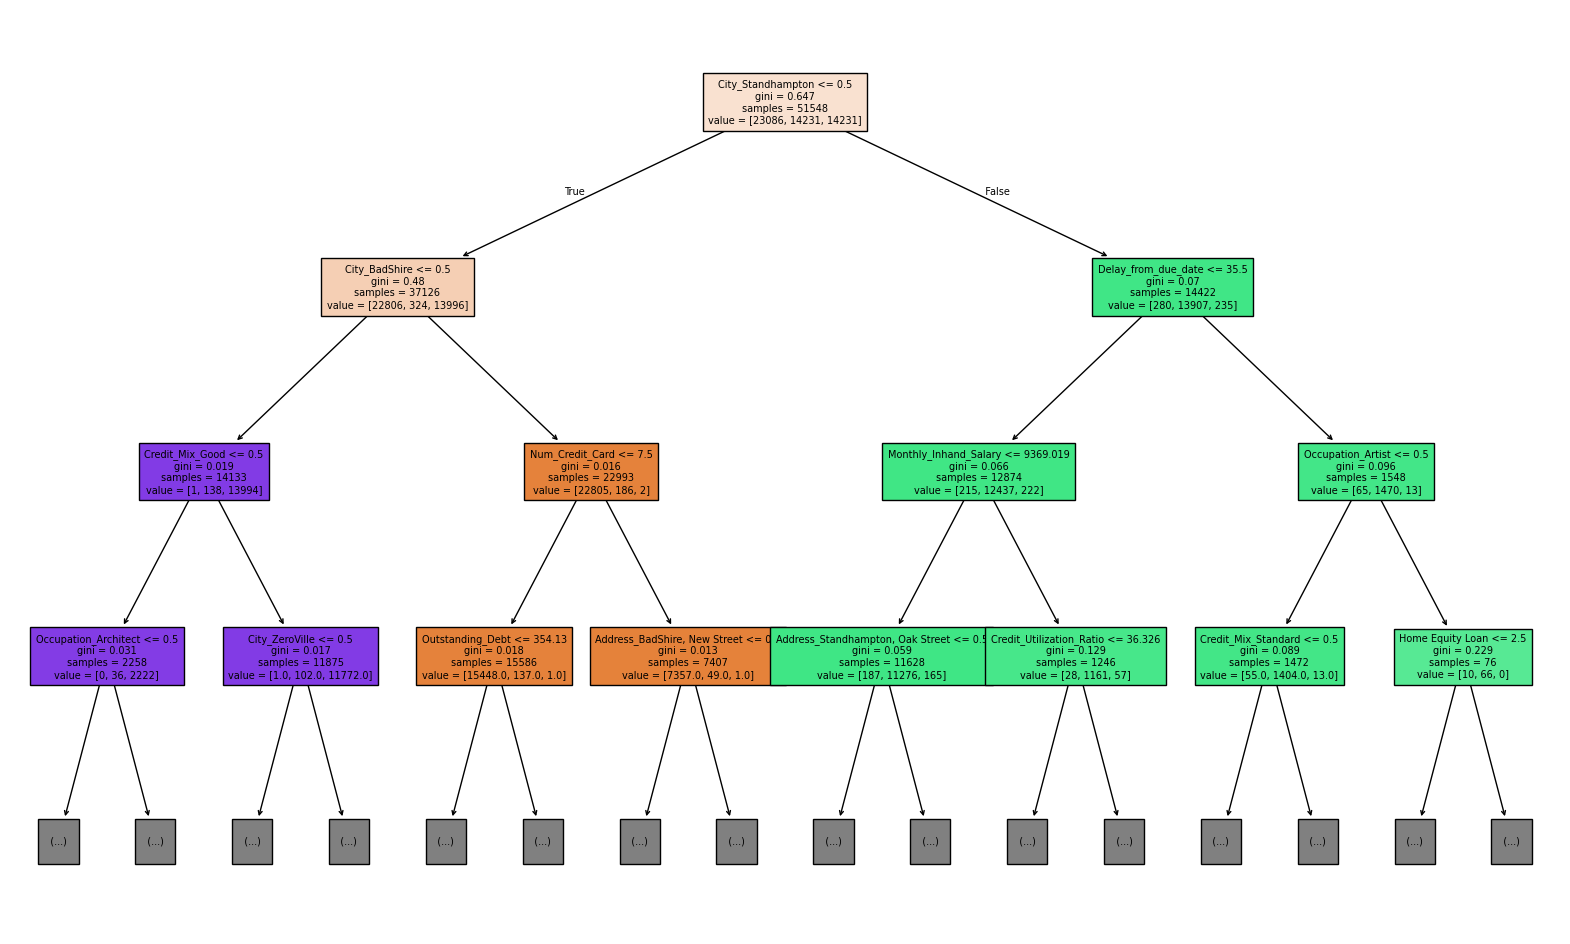

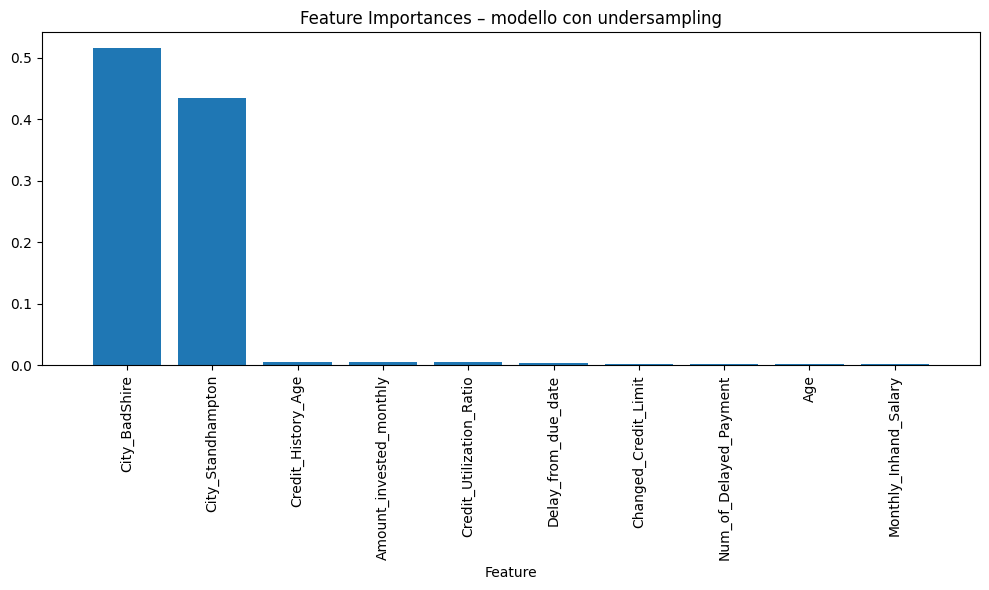

In [35]:
# ── 1. recupera l’albero addestrato ───────────────────────────────────────────
tree_model_under = pipe_under.named_steps['model']   # <─ l'albero già fit-tato

# ── 2. visualizza i primi 3 livelli dell’albero ───────────────────────────────
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.title("Decision Tree (undersampling) – max_depth = 3", fontsize=16)

plot_tree(
    tree_model_under,
    filled=True,
    feature_names=X.columns,   # o X_train_orig.columns se preferisci
    max_depth=3,
    fontsize=7
)
plt.show()

# ── 3. feature importances (top-10) ───────────────────────────────────────────
import numpy as np

importances = tree_model_under.feature_importances_
indices     = np.argsort(importances)[::-1]          # ordina desc
features    = X.columns[indices]                    # stesse feature-names
importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances – modello con undersampling")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


RandomForest + SMOTE  |  CV macro-F1: 0.981 ± 0.001

Confusion matrix (RandomForest):
[[ 5778    88     1]
 [  129 10362    82]
 [    0    60  3430]]

Classification report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98      5867
           2       0.99      0.98      0.98     10573
           3       0.98      0.98      0.98      3490

    accuracy                           0.98     19930
   macro avg       0.98      0.98      0.98     19930
weighted avg       0.98      0.98      0.98     19930



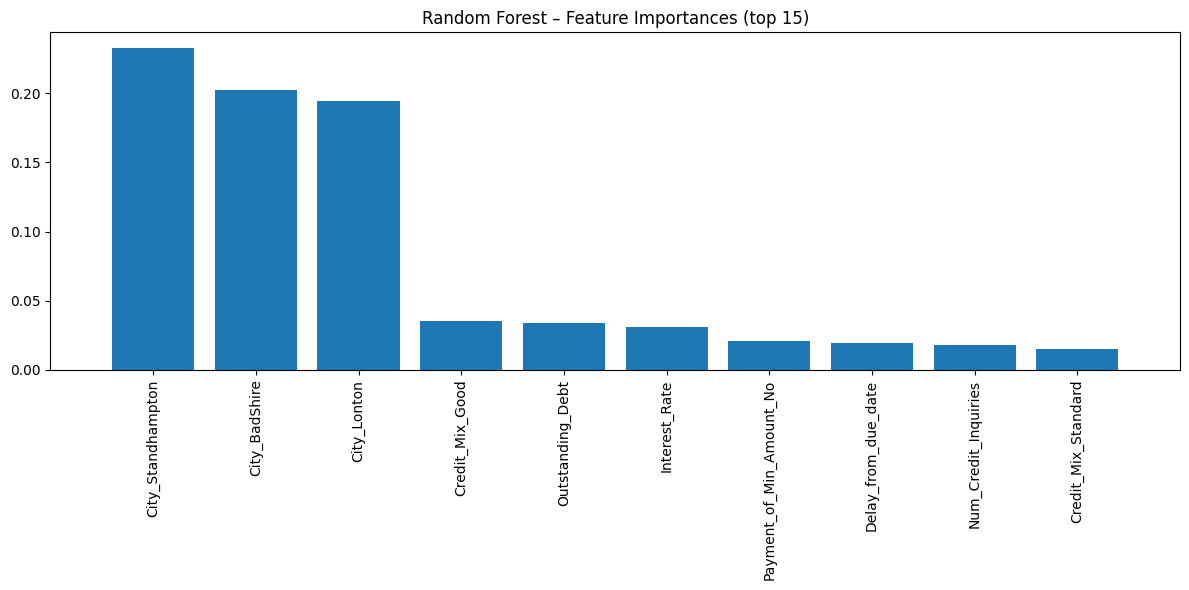

In [ ]:
# ------------------------------------------------------------------
# 1)  nuovo SMOTE + RandomForest nella stessa logica del vecchio modello
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,          # lascia crescere liberamente
    min_samples_leaf=2,      # piccolo smoothing delle foglie
    n_jobs=-1,
    random_state=42
)

pipe_rf = Pipeline([
    ('smote', smote),
    ('model', rf_clf)
])

# ------------------------------------------------------------------
# 2)  cross-validation (macro-F1) sul train oversamplato internamente
# ------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_rf = cross_val_score(
    pipe_rf, X_train, y_train,
    cv=cv, scoring='f1_macro'
)
print(f"RandomForest + SMOTE  |  CV macro-F1: {scores_rf.mean():.3f} ± {scores_rf.std():.3f}")

# ------------------------------------------------------------------
# 3)  fit finale e valutazione sul test vero (distribuzione reale)
# ------------------------------------------------------------------
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion matrix (RandomForest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification report:")
print(classification_report(y_test, y_pred_rf))

# ------------------------------------------------------------------
# 4)  feature importances (top-15) ---------------------------------
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

rf_model = pipe_rf.named_steps['model']           # attento: prendi l'estimator addestrato

importances = rf_model.feature_importances_
idx_sorted  = np.argsort(importances)[::-1]

features    = X.columns[idx_sorted]               # stesse colonne usate nel modello
importances = importances[idx_sorted]

plt.figure(figsize=(12, 6))
plt.title("Random Forest – Feature Importances (top 10)")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()
